# Luis Eduardo Robles Jiménez

### Natural Language Processing

### Practica 3: BoW y Esquemas de pesado

In [1]:
def get_texts_from_file(path_corpus, path_truth):
    txt = []
    y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for tuit in f_corpus:
            txt += [tuit]
        for label in f_truth:
            y += [label] 
    return txt, list(map(int, y))

#### Load datasets

In [2]:
tr_txt, tr_y = get_texts_from_file("../data/agresividad/mex_train.txt", "../data/agresividad/mex_train_labels.txt")

In [3]:
len(tr_txt)

5544

In [4]:
len(tr_y)

5544

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Counter({0: 3563, 1: 1981})


Text(0.5, 0, 'Class')

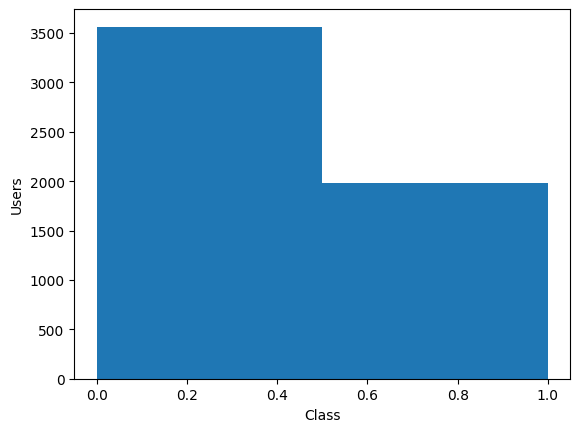

In [6]:
# See dist of labels

print(Counter(tr_y))

plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users')
plt.xlabel('Class')

In [7]:
tr_txt[:10]

['lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n',
 'a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n',
 'considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n',
 'el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n',
 'mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n',
 'putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n',
 'ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n',
 '@usuario jajjaja te digo esa madre si está buena ajjaja\n',
 'odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n',
 '@usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 

In [8]:
# Split doesn't quite work because of punctuation

set(tr_txt[5].split()) 

{'ambriados',
 'como',
 'es',
 'madre.',
 'mantenidos.',
 'matarlos',
 'mejor',
 'no',
 'ojetes.',
 'posible.',
 'putos.',
 'tienen'}

In [9]:
import nltk 
from nltk.tokenize import TweetTokenizer # Tokenizer for social networks

In [10]:
tokenizer = TweetTokenizer()

## Tokenizar un tweet

In [11]:
tokenizer.tokenize(tr_txt[5])

['putos',
 '.',
 'no',
 'tienen',
 'madre',
 '.',
 'ambriados',
 'mantenidos',
 '.',
 'ojetes',
 '.',
 'como',
 'es',
 'posible',
 '.',
 'mejor',
 'matarlos']

In [12]:
tokenizer.tokenize("Hola @nick como estas #felizdia bye!!! hola@")

['Hola',
 '@nick',
 'como',
 'estas',
 '#felizdia',
 'bye',
 '!',
 '!',
 '!',
 'hola',
 '@']

In [13]:
tokenizer.tokenize("https://www.youtube.com/watch?v=dhhS_g78X2E @")

['https://www.youtube.com/watch?v=dhhS_g78X2E', '@']

In [14]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc) # A single list
    #corpus_palabras += [tokenizer.tokenize(doc)] # Creates a list of lists

In [15]:
len(set(corpus_palabras))

13580

In [16]:
fdist = nltk.FreqDist(corpus_palabras) # Frequency of each word
fdist

FreqDist({'que': 3383, 'de': 3357, '.': 2774, 'a': 2629, 'la': 2433, 'y': 2266, 'no': 1824, 'me': 1613, '!': 1505, 'el': 1303, ...})

In [17]:
def sortFreqDist(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [18]:
V = sortFreqDist(fdist) # Vocabulario
V = V[:5000]
V[:10]

[(3383, 'que'),
 (3357, 'de'),
 (2774, '.'),
 (2629, 'a'),
 (2433, 'la'),
 (2266, 'y'),
 (1824, 'no'),
 (1613, 'me'),
 (1505, '!'),
 (1303, 'el')]

In [19]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1
print(len(dict_indices))
list(dict_indices)[:10]

5000


['que', 'de', '.', 'a', 'la', 'y', 'no', 'me', '!', 'el']

In [20]:
val_txt, val_y = get_texts_from_file("../data/agresividad/mex_val.txt", "../data/agresividad/mex_val_labels.txt")

Counter({0: 397, 1: 219})


Text(0.5, 0, 'Class')

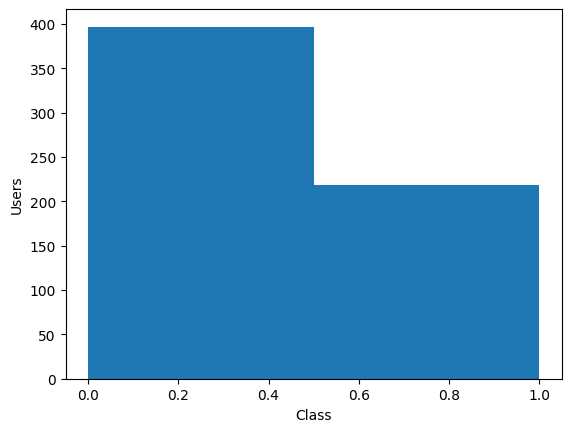

In [21]:
# See dist of labels
print(Counter(val_y))

plt.hist(val_y, bins=len(set(val_y)))
plt.ylabel('Users')
plt.xlabel('Class')

## Bag of Words

In [22]:
import numpy as np

### Binary bag of words

In [23]:
def build_binary_bow(tr_txt, V, dict_indices): #List of all tweets, vocabulary, ordered dict(word, freq)
    BOW = np.zeros((len(tr_txt),len(V)), dtype = int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = 1
        cont_doc += 1
    return BOW #Returns a matrix of nDocs x nWords (first 5000 words)

### TCOR

In [24]:
# It works with binary BOW
def myTCOR(BOW): 
    BOW = BOW.T
    vocabSize = BOW.shape[0]
    tcor = np.zeros((vocabSize, vocabSize), dtype = float)
    for ik in range(vocabSize):
        print(ik, '\r', end = "")
        occur = np.count_nonzero(np.sum(BOW[:, np.nonzero(BOW[ik])], axis = 1)) # Gets the number of words t_k co-occurs with
        for ij in range(vocabSize):
            if ij >= ik:
                freq, tff = np.count_nonzero(np.logical_and(BOW[ik], BOW[ij])), 0 # Gets the number of docs where t_k co-occurs with t_j
                if freq: tff = 1 + np.log(freq)
                tcor[ik, ij] = tff * np.log(vocabSize / occur)
                tcor[ij, ik] = tff
            else: 
                tcor[ik, ij] *= np.log(vocabSize / occur)
    return tcor

def RicksTCOR(BOW):
    nDocs, nWords = BOW.shape
    tcor = np.zeros((nWords, nWords), dtype = float)
    a = np.zeros_like(tcor, dtype = float)
    for doc in range(nDocs): a[BOW[doc] == 1] += BOW[doc]
    for k in range(nWords):
        tk = np.count_nonzero(a[k])
        for j in range(nWords):
            tcor[k, j] = np.log(nWords/tk)
            tcor[k, j] *= (1 + np.log(a[k, j]) if a[k, j] > 0 else 0)
    return tcor

def TCOR(BOW):
    nDocs, nWords = BOW.shape
    tcor = np.zeros((nWords, nWords), dtype = float)
    a = np.zeros_like(tcor, dtype = float)
    for doc in range(nDocs): tcor[BOW[doc] == 1] += BOW[doc]
    print(np.unique(tcor))
    tcor = np.where(tcor > 0., 1 + np.log(tcor), 0)
    print(np.unique(tcor))
    #tcor = np.where(tcor > 0., 1 + np.log(2), 0)
    tk = np.log(nWords / np.count_nonzero(tcor, axis = 1))
    tcor = np.multiply(tcor, tk)
    return tcor

In [25]:
# It works with binary BOW
def myTCOR(BOW): 
    BOW = BOW.T
    vocabSize = BOW.shape[0]
    tcor = np.zeros((vocabSize, vocabSize), dtype = float)
    for ik in range(vocabSize):
        print(ik, '\r', end = "")
        occur = np.count_nonzero(np.sum(BOW[:, np.nonzero(BOW[ik])], axis = 1)) # Gets the number of words t_k co-occurs with
        for ij in range(vocabSize):
            if ij >= ik:
                freq, tff = np.count_nonzero(np.logical_and(BOW[ik], BOW[ij])), 0 # Gets the number of docs where t_k co-occurs with t_j
                if freq: tff = 1 + np.log(freq)
                tcor[ik, ij] = tff * np.log(vocabSize / occur)
                tcor[ij, ik] = tff
            else: 
                tcor[ik, ij] *= np.log(vocabSize / occur)
    return tcor

def RicksTCOR(BOW):
    nDocs, nWords = BOW.shape
    tcor = np.zeros((nWords, nWords), dtype = float)
    a = np.zeros_like(tcor, dtype = float)
    for doc in range(nDocs): a[BOW[doc] == 1] += BOW[doc]
    for k in range(nWords):
        tk = np.count_nonzero(a[k])
        for j in range(nWords):
            tcor[k, j] = np.log(nWords/tk)
            tcor[k, j] *= (1 + np.log(a[k, j]) if a[k, j] > 0 else 0)
    return tcor

def TCOR(BOW):
    nDocs, nWords = BOW.shape
    tcor = np.zeros((nWords, nWords), dtype = float)
    for doc in range(nDocs): tcor[BOW[doc] == 1] += BOW[doc]
    tcor = np.where(tcor > 0, np.log(tcor, where = tcor > 0) + 1, 0)
    tcor = np.multiply(tcor.T, np.log(nWords / np.count_nonzero(tcor, axis = 1))).T
    return tcor

## Experiments

In [26]:
a = np.ones((3, 5))
np.count_nonzero(a, axis = 1)

array([5, 5, 5], dtype=int64)

### TCOR - BOC

In [27]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2

In [28]:
BOW_tr = build_binary_bow(tr_txt, V, dict_indices)

In [29]:
TCOR(BOW_tr)

array([[1.748512  , 1.59747316, 1.56697616, ..., 0.        , 0.        ,
        0.19820707],
       [1.17258012, 1.28747314, 1.15619208, ..., 0.        , 0.        ,
        0.        ],
       [2.08890554, 2.09979765, 2.28395946, ..., 0.264226  , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 5.38169898, ..., 5.38169898, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 5.95224383,
        0.        ],
       [6.03228654, 0.        , 0.        , ..., 0.        , 0.        ,
        6.03228654]])

In [30]:
import time

In [31]:
tcors = {"First approach": myTCOR, "Rick's approach": RicksTCOR, "Resulting TCOR": TCOR}
r = []

In [32]:
for tcor in tcors:
    start = time.perf_counter()
    base = tcors[tcor](BOW_tr)
    end = time.perf_counter()
    print(f'{tcor} ran for {end - start} seconds')

First approach ran for 521.7572392000001 seconds
Rick's approach ran for 32.25554639999996 seconds
Resulting TCOR ran for 1.2322444999999789 seconds


In [33]:
base = preprocessing.normalize(base, norm = "l2")

In [34]:
feats = SelectKBest(chi2, k = 1000)
#feats = SelectKBest(chi2, k = 50)
feats.fit(BOW_tr, tr_y)

SelectKBest(k=1000, score_func=<function chi2 at 0x000001255EABB790>)

In [35]:
best = feats.get_support(indices = True)
print(best.shape)

(1000,)


In [36]:
# Goes from word -> key to key -> word

dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w

In [37]:
t_words = [dict_indice_invertido[index] for index in best]

In [38]:
# dict_indices['palabra'] = 201
target_matrix = np.array([base[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 5000)

In [39]:
from tsne import tsne

In [40]:
reduced_matrix = tsne(target_matrix, 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.167819
Iteration 10: error is 17.786544
Iteration 20: error is 17.551975
Iteration 30: error is 17.447226
Iteration 40: error is 17.427086
Iteration 50: error is 17.386578
Iteration 60: error is 17.408091
Iteration 70: error is 17.405180
Iteration 80: error is 17.404407
Iteration 90: error is 17.403598
Iteration 100: error is 17.404439
Iteration 110: error is 2.238746
Iteration 120: error is 1.857540
Iteration 130: error is 1.716178
Iteration 140: error is 1.636831
Iteration 150: error is 1.584384
Iteration 160: error is 1.547832
Iteration 170: error is 1.520584
Iteration 180: error is 1.498709
Iteration 190: error is 1.481012
Iteration 200: error is 1.466932
Iteration 210: error is 1.455363
Iteration 220: error is 1.445581
Iteration 230: error is 1.437293
Iteration 240: error is 1.430426
Iteration 250: error is

In [41]:
reduced_matrix.shape

(1000, 2)

C:\Users\lalor\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  func(*args, **kwargs)
C:\Users\lalor\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  func(*args, **kwargs)
C:\Users\lalor\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
C:\Users\lalor\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  func(*args, **kwargs)
C:\Users\lalor\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from current font.
  func(*args, **kwargs)
C:\Users\lalor\AppData\Roaming\Python\Python39\s

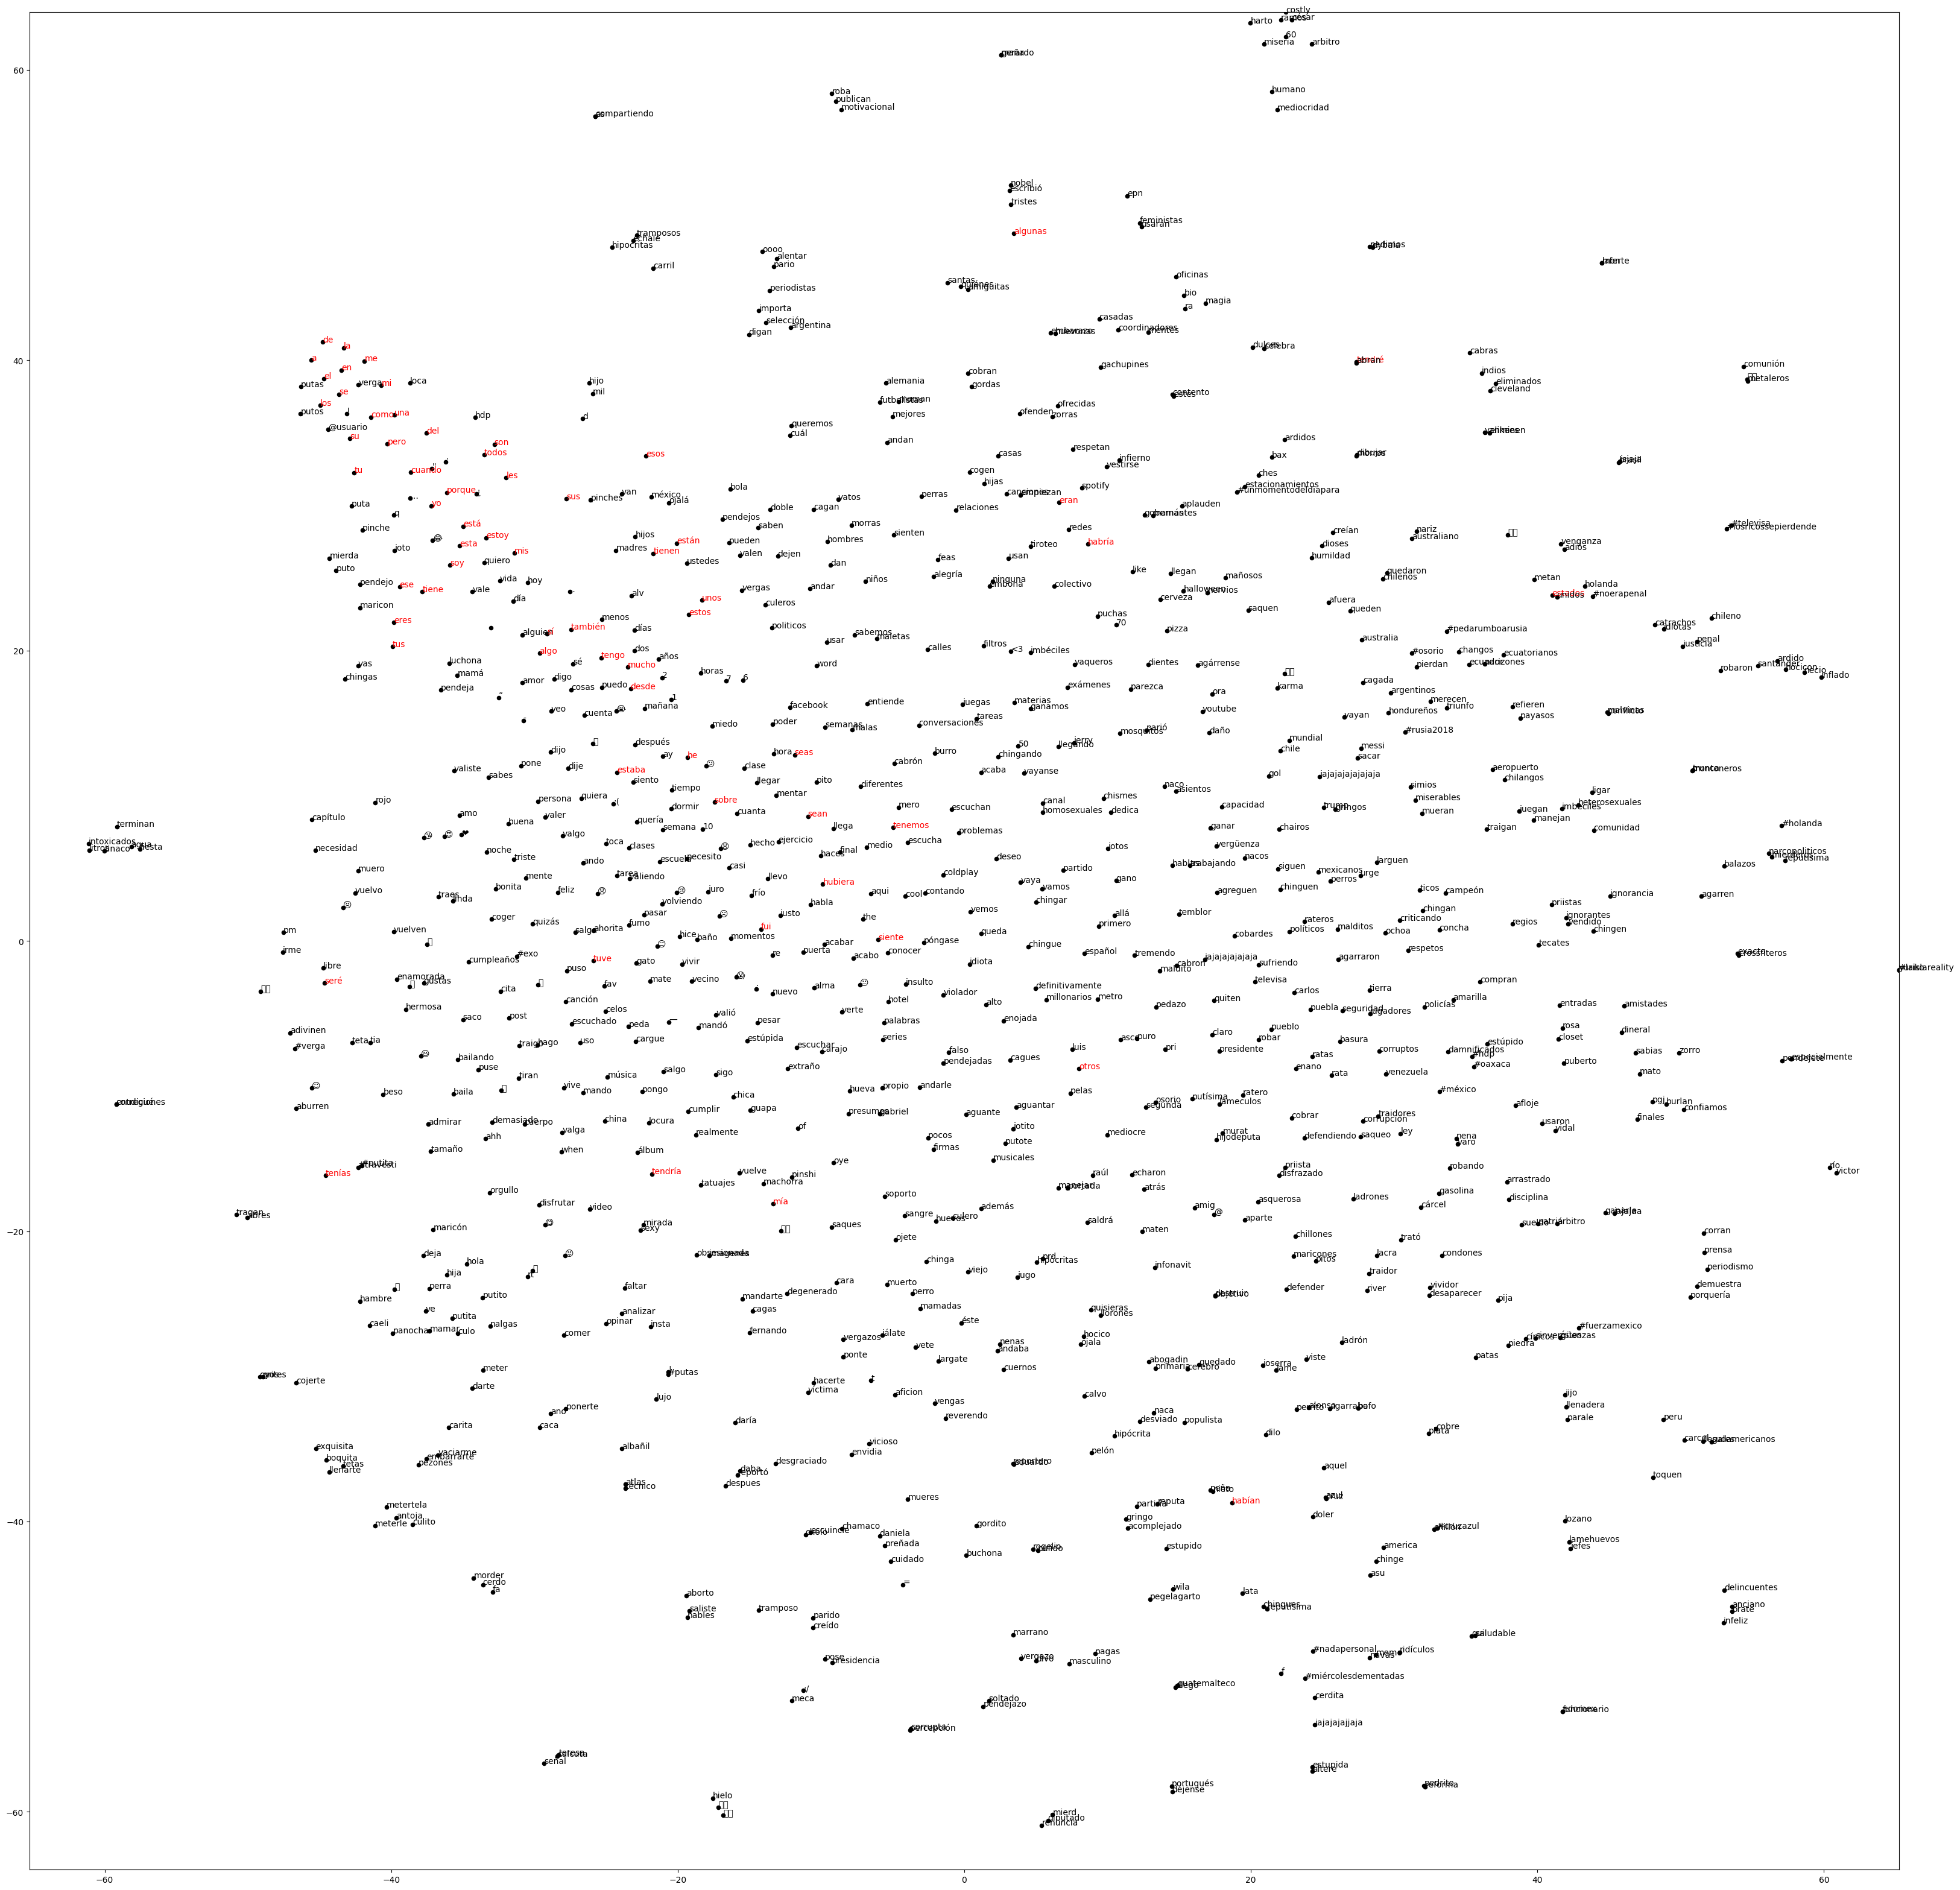

In [42]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40, 40), dpi=100)
plt.xlim((-max_x,max_x))
plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black");

for idx, word in enumerate(t_words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]  
    if word in sw:
        plt.annotate(word, (x,y), color="red")
    else: 
        plt.annotate(word, (x,y), color="black")

## Conclusion

Tras llevar a cabo la implementacion de sistema de representacion TCOR puedo intuir que tiene mayor potencial para agrupar las palabras y representar un corpus, ya que es de tipo words-words. Me es bastante claro que el cálculo es demandante en cuestion de tiempo y complejidad de implementacion pero es asequible y util. 
Otra cosa que es importante notar es que este tipo de representacion es de naturaleza distribucional y vectorial. Su motivacion es pensar que la semantica de una palabra puede ser explicada por las palabras con las que esta coincide, en terminos coloquiales "dime con quien te juntas y te dire quien eres".
Basados en la definicion del pesado, se pueden decir las siguientes cosas:

- Entre en mas documentos co-ocurra t_k con t_j, mas explicara t_k la semantica de t_j.
- Por otro lado, entre mas palabras de co-ocurrencia con t_k haya, menos servira para explicar la semantica de t_j.

Las diferencias entre el sistema de pesado TCOR y sistema de pesado DOR:

- DOR genera una matriz de tamaño -> Palabras x Documentos; TCOR genera una matriz de tamaño -> Palabras x Palabras.
- Aunque parten de premisas similares, ambos sistemas de pesado representan ventajas diferentes, pero basado en experimentos extrinsecos, TCOR parece ser capaz de atrapar un poco mas de semantica y explicar mejor el corpus a traves de term clustering.
Sin duda, esta ha sido una actividad retadora pero ha dejado buen aprendizaje por detras, reforzado aun mas por la comparacion con DOR.
